In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import textwrap
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid

In [2]:
# figure root
fig_root = os.path.join(os.environ['HOME'], 'work', 'cmip6', 'projection', 'figures')
save_fig = True

In [3]:
datadir     = os.path.join(os.environ['HOME'], 'project', 'cmip6_projection', 'data')
histdir     = datadir+'/ensemble_average_historical'
histdir_ghg = datadir+'/ensemble_average_historical-ghg'
projdir     = datadir+'/ensemble_average_projection'
projdir_ghg = datadir+'/ensemble_average_projection-ghg'
hist_season_jas = 'JAS_198507_201409'
hist_season_jfm = 'JFM_198501_201403'
proj_season_jas = 'JAS_207007_209909'
proj_season_jfm = 'JFM_207001_209903'

In [4]:
def get_diff_clim(varname, histdir, projdir, hist_season, proj_season, ndim=3):
    hist = histdir+'/mpaso_'+hist_season+'_climo_rgr.nc'
    proj = projdir+'/mpaso_'+proj_season+'_climo_rgr.nc'
    if ndim == 3:
        with xr.open_dataset(hist) as ds:
            hist_da = ds.data_vars[varname][0,0,:,:]
        with xr.open_dataset(proj) as ds:
            proj_da = ds.data_vars[varname][0,0,:,:]
    elif ndim == 2:
        with xr.open_dataset(hist) as ds:
            hist_da = ds.data_vars[varname][0,:,:]
        with xr.open_dataset(proj) as ds:
            proj_da = ds.data_vars[varname][0,:,:]
    else:
        raise ValueError('ndim should be 3 or 2')
    diff_da = proj_da - hist_da
    diff_da.attrs['units'] = hist_da.attrs['units']
    diff_da.attrs['long_name'] = '$\Delta $'+hist_da.attrs['long_name']
    return diff_da

def plot_diff_clim(diff_da, cmap = 'viridis', levels=None, ax=None, colorbar=True, **kwargs):
    if ax is None:
        ax = plt.gca()
    m = Basemap(projection='cyl', llcrnrlat=-90., urcrnrlat=90.,
                llcrnrlon=20., urcrnrlon=380., ax=ax)
    # plot coastlines, draw label meridians and parallels.
    m.drawcoastlines(zorder=3)
    m.drawmapboundary(fill_color='lightgray')
    m.fillcontinents(color='gray',lake_color='lightgray', zorder=2)
    m.drawparallels(np.arange(-90.,91.,30.), labels=[1,0,0,1])
    m.drawmeridians(np.arange(-180.,181.,60.), labels=[1,0,0,1])
    data = diff_da.data.squeeze()
    lon = diff_da.lon.data
    lat = diff_da.lat.data 
    data, lon = shiftgrid(20., data, lon, start=True, cyclic=360.)
    lon2d, lat2d = np.meshgrid(lon, lat)
    if levels is not None:
        bounds = np.array(levels)
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    else:
        norm = None
    xx, yy = m(lon2d, lat2d)
    fig = m.contourf(xx, yy, data, levels=levels, extend='both',
                     norm=norm, cmap=plt.cm.get_cmap(cmap), **kwargs)
    # add colorbar
    if colorbar:
        cb = m.colorbar(fig, ax=ax)
        cb_label = '\n'.join(textwrap.wrap('{} ({})'.format(diff_da.attrs['long_name'], 
                                                            diff_da.attrs['units']), 30))
        cb.set_label(cb_label)
        cb.formatter.set_powerlimits((-4, 4)) 
        cb.update_ticks()
    return fig
    
def plot_diff_clim_all(diff_jfm_da, diff_jas_da, diff_jfm_da_ghg, diff_jas_da_ghg,
                      levels, cblabel):
    fig, axarr = plt.subplots(2, 2)
    fig.set_size_inches([10, 5])
    im = plot_diff_clim(diff_jfm_da, levels=levels, cmap='RdBu_r', colorbar=False, ax=axarr[0,0])
    plot_diff_clim(diff_jas_da, levels=levels, cmap='RdBu_r', colorbar=False, ax=axarr[1,0])
    plot_diff_clim(diff_jfm_da_ghg, levels=levels, cmap='RdBu_r', colorbar=False, ax=axarr[0,1])
    plot_diff_clim(diff_jas_da_ghg, levels=levels, cmap='RdBu_r', colorbar=False, ax=axarr[1,1])
    axarr[0,0].set_title('All forcing')
    axarr[0,1].set_title('GHG only')
    axarr[0,0].text(0.05, 0.85, '(a) JFM', transform=axarr[0,0].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[0,1].text(0.05, 0.85, '(b) JFM', transform=axarr[0,1].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[1,0].text(0.05, 0.85, '(c) JAS', transform=axarr[1,0].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[1,1].text(0.05, 0.85, '(d) JAS', transform=axarr[1,1].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    # reduce margin
    plt.tight_layout()

    # colorbar
    plt.subplots_adjust(right=0.9)
    plt.subplots_adjust(top=0.95)
    cax = plt.axes([0.83, 0.05, 0.1, 0.9])
    cax.set_visible(False)
    cb = plt.colorbar(im, ax=cax)
    cb.set_label(cblabel)
    return fig

In [5]:
varname = 'timeMonthly_avg_activeTracers_temperature'
diff_jas_da = get_diff_clim(varname, histdir, projdir, hist_season_jas, proj_season_jas)
diff_jfm_da = get_diff_clim(varname, histdir, projdir, hist_season_jfm, proj_season_jfm)
diff_jas_da_ghg = get_diff_clim(varname, histdir_ghg, projdir_ghg, hist_season_jas, proj_season_jas)
diff_jfm_da_ghg = get_diff_clim(varname, histdir_ghg, projdir_ghg, hist_season_jfm, proj_season_jfm)


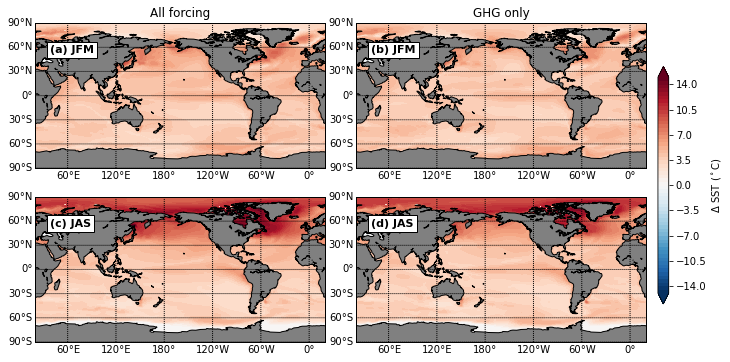

In [6]:
levels = np.linspace(-15, 15, 61)
cblabel= '$\Delta$ SST ($^\circ$C)'
fig = plot_diff_clim_all(diff_jfm_da, diff_jas_da, diff_jfm_da_ghg, diff_jas_da_ghg, levels, cblabel)
if save_fig:
    figname = fig_root+'/CMIP6_ScenarioMIP_Map_SST.png'
    fig.savefig(figname, dpi = 300)

In [7]:
varname = 'timeMonthly_avg_activeTracers_salinity'
diff_jas_da = get_diff_clim(varname, histdir, projdir, hist_season_jas, proj_season_jas)
diff_jfm_da = get_diff_clim(varname, histdir, projdir, hist_season_jfm, proj_season_jfm)
diff_jas_da_ghg = get_diff_clim(varname, histdir_ghg, projdir_ghg, hist_season_jas, proj_season_jas)
diff_jfm_da_ghg = get_diff_clim(varname, histdir_ghg, projdir_ghg, hist_season_jfm, proj_season_jfm)


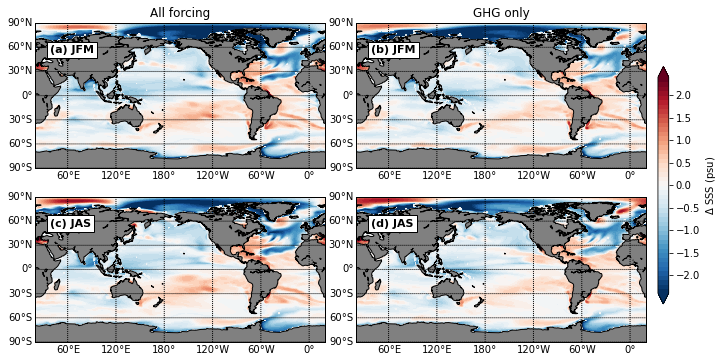

In [8]:
levels = np.linspace(-2.4, 2.4, 49)
cblabel= '$\Delta$ SSS (psu)'
fig = plot_diff_clim_all(diff_jfm_da, diff_jas_da, diff_jfm_da_ghg, diff_jas_da_ghg, levels, cblabel)
if save_fig:
    figname = fig_root+'/CMIP6_ScenarioMIP_Map_SSS.png'
    fig.savefig(figname, dpi = 300)

In [9]:
varname = 'timeMonthly_avg_dThreshMLD'
diff_jas_da = get_diff_clim(varname, histdir, projdir, hist_season_jas, proj_season_jas, ndim=2)
diff_jfm_da = get_diff_clim(varname, histdir, projdir, hist_season_jfm, proj_season_jfm, ndim=2)
diff_jas_da_ghg = get_diff_clim(varname, histdir_ghg, projdir_ghg, hist_season_jas, proj_season_jas, ndim=2)
diff_jfm_da_ghg = get_diff_clim(varname, histdir_ghg, projdir_ghg, hist_season_jfm, proj_season_jfm, ndim=2)


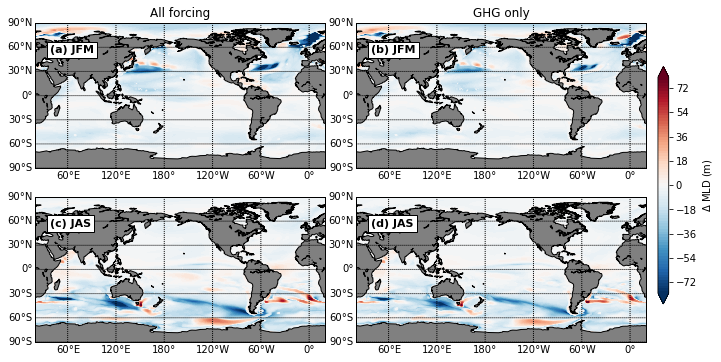

In [10]:
levels = np.array([-200, -150, -100, -80, -60, -40, -20, -10, -5, -1,
                   1, 5, 10, 20, 40, 60, 80, 100, 150, 200])
levels = np.linspace(-80, 80, 81)
cblabel= '$\Delta$ MLD (m)'
fig = plot_diff_clim_all(diff_jfm_da, diff_jas_da, diff_jfm_da_ghg, diff_jas_da_ghg, levels, cblabel)
if save_fig:
    figname = fig_root+'/CMIP6_ScenarioMIP_Map_MLD.png'
    fig.savefig(figname, dpi = 300)